<a href="https://colab.research.google.com/github/nikitosssobur/My-ML-Projects/blob/main/vgg_16_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle
import sys
from PIL import Image
from google.colab import files
from google.colab import drive
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch.nn.functional as F
from IPython.display import clear_output

**Project task: build VGG-16 model for classification of the images from CIFAR-100 dataset to 100 classes.**

In [ ]:
#Device info
print(torch.cuda.is_available())
#drive.mount('/content/drive')
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
1
0
Tesla T4
cuda


In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dictionary = pickle.load(fo, encoding='bytes')
        return dictionary

In [ ]:
#Unpack the data
data_dict = unpickle('/content/sample_data/cifar_data/train')
test_data_dict = unpickle('/content/sample_data/cifar_data/test')
meta_data_dict = unpickle('/content/sample_data/cifar_data/meta')
print(data_dict.keys())
print(f'Keys of the meta data dictionary: {meta_data_dict.keys()}')
print(f'Number of classes label names: {len(meta_data_dict[b"fine_label_names"])}')
print(f'Class label names: {meta_data_dict[b"fine_label_names"]}')
print(f'Number of superclasses label names: {len(meta_data_dict[b"coarse_label_names"])}')
print(f'Class label names: {meta_data_dict[b"coarse_label_names"]}')


dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
Keys of the meta data dictionary: dict_keys([b'fine_label_names', b'coarse_label_names'])
Number of classes label names: 100
Class label names: [b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'r

In [ ]:
print(min(data_dict[b'fine_labels']), max(data_dict[b'fine_labels']))
classes_labels = np.arange(0, 100)
classes_labels

0 99


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
def divide_labels_by_classes(data_list, labels):
    data = np.array(data_list)
    labels_dict = {label: np.where(data == label)[0] for label in labels}
    return labels_dict

#labels_dict = divide_labels_by_classes(data_dict[b'fine_labels'], classes_labels)
#labels_dict[0]
train_labels_dict = divide_labels_by_classes(data_dict[b'fine_labels'], classes_labels)
test_labels_dict = divide_labels_by_classes(test_data_dict[b'fine_labels'], classes_labels)

'''
Создай список и посмотри сколько сколько картинок получается по каждому классу
'''
num_of_images_per_class_train = [len(train_labels_dict[label]) for label in train_labels_dict]
num_of_images_per_class_test = [len(test_labels_dict[label]) for label in test_labels_dict]
print(num_of_images_per_class_train)
print(num_of_images_per_class_test)

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

In [ ]:
#Preprocessing pipeline

#Function returns numerical data of fixed image for choosen channel (red, green or blue)
def get_channel_data(data_dict, img_number, channel):
    if channel == 'red':  return data_dict[b'data'][img_number][: 1024]
    elif channel == 'blue':   return data_dict[b'data'][img_number][1024 : 2048]
    else: return data_dict[b'data'][img_number][2048: ]


#Function returns reshaped image (32 x 32)
def reshape_img(channel_data, width, height):
    return np.reshape(channel_data, (width, height))


#Function returns preprocessed image by taken number
def image_preprocessing(data_dict, img_number):
    red_channel = get_channel_data(data_dict, img_number, 'red')
    blue_channel = get_channel_data(data_dict, img_number, 'blue')
    green_channel = get_channel_data(data_dict, img_number, 'green')

    rc_matrix = reshape_img(red_channel, 32, 32)
    bc_matrix = reshape_img(blue_channel, 32, 32)
    gc_matrix = reshape_img(green_channel, 32, 32)

    red_img = Image.fromarray(rc_matrix, mode="L")
    green_img = Image.fromarray(gc_matrix, mode="L")
    blue_img = Image.fromarray(bc_matrix, mode="L")

    width, height = red_img.size
    result_img = Image.new('RGB', (width, height))
    result_img.putdata(list(zip(red_img.getdata(), green_img.getdata(), blue_img.getdata())))
    return result_img


def create_sample(data_dict):
    new_data = [image_preprocessing(data_dict, img_number) for img_number in range(len(data_dict[b'data']))]
    return new_data


def create_batch(data_dict, batch_size):
    labels_dict = divide_labels_by_classes(data_dict[b'fine_labels'], classes_labels)
    labels_num = len(labels_dict)
    images_per_class_num, residual_images_num = batch_size // labels_num, batch_size % labels_num
    if images_per_class_num > 0:
        for label in iter(labels_dict):
            if label == 0:
                random_indices = np.random.choice(labels_dict[label], size = images_per_class_num)
            else:
                random_label_indices = np.random.choice(labels_dict[label], size = images_per_class_num)
                random_indices = np.concatenate((random_indices, random_label_indices))

        if residual_images_num != 0:
            residual_labels = ([np.random.randint(0, labels_num) for i in range(residual_images_num)])
            residual_random_indices = np.array([np.random.choice(labels_dict[label]) for labels in residual_labels])
            random_indices = np.concatenate((random_indices, residual_random_indices))

    else:
        random_indices = np.random.choice(data_dict[b'fine_labels'], size = batch_size)

    x_data = [image_preprocessing(data_dict, img_num) for img_num in iter(random_indices)]
    y_data = torch.tensor([data_dict[b'fine_labels'][i] for i in iter(random_indices)], dtype = torch.long, device = device)
    #return [x_data[i] for i in random_indices], y_data[random_indices]
    return x_data, y_data


def get_unique_indices_by_batches(labels_data, labels_num, epoch_num, batch_size, shuffle_mode = True):
    '''
    This function excludes already used indices and returns unique batches of images by epoch_num.
    labels_data: target label for each input image of the data_dict.
    labels_num: general number of classes.
    indices: indices of all images in the train sample
    labels: indices of labels of the classes
    batches_dict: output dictionary in the following format:
    'epoch_number'(key): list of indices of random choosen unique images by all classes size of batch_size (value)
    images_num_per_class: integer number of images in batch taken from each class
    residual_images_num: residual images in the case when batch_size % labels_num != 0
    images_num: total number of images from train data which is used in the process of training (without residual images!!)
    residual_images_num: number of residue images after integer division from batch size by labels_num
    '''
    indices, labels, batches_dict = np.arange(len(labels_data)), np.arange(labels_num), {}
    images_num_per_class, residual_images_num = batch_size // labels_num, batch_size % labels_num
    images_num = images_num_per_class * epoch_num
    indices_per_class_dict = divide_labels_by_classes(labels_data, labels)
    min_number_of_images_per_class = min(tuple([len(indices_per_class_dict[label]) for label in labels]))
    if images_num < min_number_of_images_per_class:
        for epoch in range(epoch_num):
            if images_num_per_class > 0:
                for label in labels:
                    if label == 0:
                        random_indices = np.random.choice(indices_per_class_dict[0], size = images_num_per_class)
                        indices_per_class_dict[0] = np.setdiff1d(indices_per_class_dict[0], random_indices)
                    else:
                        random_label_indices = np.random.choice(indices_per_class_dict[label], size = images_num_per_class)
                        indices_per_class_dict[label] = np.setdiff1d(indices_per_class_dict[label], random_label_indices)
                        random_indices = np.concatenate((random_indices, random_label_indices))

                if residual_images_num != 0:
                    residual_labels = np.random.choice(labels, size = residual_images_num)
                    #residual_random_indices = np.array([np.random.choice(indices_per_class_dict[label]) for label in residual_labels])
                    for label in residual_labels:
                        random_residual_label = np.array([np.random.choice(indices_per_class_dict[label])])
                        indices_per_class_dict[label] = np.setdiff1d(indices_per_class_dict[label], random_residual_label)
                        random_indices = np.concatenate((random_indices, random_residual_label))

            else:
                random_indices = np.random.choice(indices, size = batch_size)
                indices = np.setdiff1d(indices, random_indices)


            if shuffle_mode is True:  np.random.shuffle(random_indices)

            batches_dict[epoch] = random_indices
    return batches_dict



def batch_from_indices(data_dict, indices_list):
    x_data = [image_preprocessing(data_dict, img_num) for img_num in iter(indices_list)]
    y_data = torch.tensor([data_dict[b'fine_labels'][i] for i in iter(indices_list)], dtype = torch.long, device = device)
    return x_data, y_data



In [ ]:
indices_by_batches = get_unique_indices_by_batches(data_dict[b'fine_labels'], 100, 10, 400)
x_batch_data, y_batch_data = batch_from_indices(data_dict, indices_by_batches[0])
#get_unique_indices_by_batches

Type of the image: <class 'PIL.Image.Image'>
Shape of the image in np repres: (32, 32, 3)
Form of the image in numpy representation: 
 [[[ 83 178 132]
  [ 67 160 114]
  [ 61 154 108]
  ...
  [  9  57  26]
  [ 16  66  34]
  [ 35  94  59]]

 [[ 75 173 124]
  [ 71 167 119]
  [ 55 152 103]
  ...
  [ 39 107  67]
  [  9  65  28]
  [ 12  66  31]]

 [[ 73 173 121]
  [ 68 166 115]
  [ 74 172 122]
  ...
  [ 91 178 132]
  [ 53 125  83]
  [ 14  70  34]]

 ...

 [[159 223 187]
  [150 159 146]
  [191 143 154]
  ...
  [152 136 131]
  [173 158 143]
  [122 150 123]]

 [[157 202 171]
  [155 132 133]
  [183 141 152]
  ...
  [213 159 168]
  [196 153 146]
  [169 180 157]]

 [[150 186 160]
  [155 122 127]
  [179 139 149]
  ...
  [212 148 159]
  [187 135 136]
  [148 154 135]]]


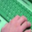

In [ ]:
#Image example
processed_image = image_preprocessing(data_dict, 10)
print(f'Type of the image: {type(processed_image)}')
np_image_repres = np.array(processed_image)
torch_image_repres = transforms.functional.pil_to_tensor(processed_image)
print(f'Shape of the image in np repres: {np.shape(np_image_repres)}')
print(f'Form of the image in numpy representation: \n {np_image_repres}')
processed_image


In [ ]:
#Differences between representations
print(f'Shape of the image in torch representation: {torch_image_repres.size()}')
print(f'Form of the image in torch representation: \n {torch_image_repres}')
print(f'{torch_image_repres[0]}, \n, {torch_image_repres[0].size()}')

Shape of the image in torch representation: torch.Size([3, 32, 32])
Form of the image in torch representation: 
 tensor([[[ 83,  67,  61,  ...,   9,  16,  35],
         [ 75,  71,  55,  ...,  39,   9,  12],
         [ 73,  68,  74,  ...,  91,  53,  14],
         ...,
         [159, 150, 191,  ..., 152, 173, 122],
         [157, 155, 183,  ..., 213, 196, 169],
         [150, 155, 179,  ..., 212, 187, 148]],

        [[178, 160, 154,  ...,  57,  66,  94],
         [173, 167, 152,  ..., 107,  65,  66],
         [173, 166, 172,  ..., 178, 125,  70],
         ...,
         [223, 159, 143,  ..., 136, 158, 150],
         [202, 132, 141,  ..., 159, 153, 180],
         [186, 122, 139,  ..., 148, 135, 154]],

        [[132, 114, 108,  ...,  26,  34,  59],
         [124, 119, 103,  ...,  67,  28,  31],
         [121, 115, 122,  ..., 132,  83,  34],
         ...,
         [187, 146, 154,  ..., 131, 143, 123],
         [171, 133, 152,  ..., 168, 146, 157],
         [160, 127, 149,  ..., 159, 136, 1

In [ ]:
#Deeply understanding what is the format of image
print(np_image_repres[0], '\n', np.shape(np_image_repres[0]))
print((np.min(np_image_repres), np.max(np_image_repres)))

[[ 83 178 132]
 [ 67 160 114]
 [ 61 154 108]
 [ 58 155 108]
 [ 66 165 117]
 [ 72 171 124]
 [ 59 158 111]
 [ 50 151 102]
 [ 64 167 114]
 [ 63 166 114]
 [ 62 165 113]
 [ 61 165 112]
 [ 53 160 104]
 [ 42 149  92]
 [ 57 164 107]
 [ 62 169 113]
 [ 73 171 120]
 [121 212 165]
 [137 227 181]
 [131 222 175]
 [127 214 171]
 [112 191 156]
 [ 72 148 113]
 [ 64 136 101]
 [ 94 165 130]
 [106 187 147]
 [ 98 177 138]
 [ 73 141 106]
 [ 29  85  54]
 [  9  57  26]
 [ 16  66  34]
 [ 35  94  59]] 
 (32, 3)
(5, 255)


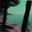

In [ ]:
test_image = image_preprocessing(test_data_dict, 10)
test_image

In [ ]:
#Creating random image in the shape of images from dataset for testing our model
some_data = torch.randint(0, 255, (3, 32, 32), dtype = torch.uint8)
some_data

tensor([[[ 55, 121, 214,  ..., 132,  16,  57],
         [213, 201, 100,  ...,  46, 174,  12],
         [ 95, 159, 144,  ..., 140, 233, 213],
         ...,
         [ 70, 139, 125,  ..., 113, 197,  26],
         [ 61, 162, 119,  ..., 187, 165, 214],
         [ 91,  17, 185,  ..., 122,  61, 220]],

        [[ 78, 161, 252,  ..., 158, 241, 119],
         [200,   2,  49,  ..., 246, 168,  29],
         [129, 199,   0,  ...,   9,  89, 150],
         ...,
         [ 79, 170,  33,  ...,  76, 235, 201],
         [123, 184, 189,  ..., 238, 163, 137],
         [ 56,  54, 222,  ..., 166, 175, 249]],

        [[157, 152,   6,  ..., 128, 124, 106],
         [220, 161,  95,  ...,  95, 133,  85],
         [108, 133,  92,  ..., 228,  10,  94],
         ...,
         [ 72,   3, 225,  ..., 116, 103, 244],
         [232,  14,  58,  ...,  65,  29, 201],
         [125, 238, 239,  ..., 138,  27, 167]]], dtype=torch.uint8)

# **Creating models**


In [ ]:
#Creating VGG-16 model

vgg_transforms = transforms.Compose([transforms.Resize(224), #resizing image to 224 x 224
        transforms.ToTensor(), #changing format of image from PIL Image to torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #normalizing pixels of input image)


class ConvNetVGG(nn.Module):
    #VGG-16 model implementation
    def __init__(self):
        #input image shape: 224 x 224 x 3
        super().__init__()
        self.kernel_size, self.padding, self.pool_kernel_size = (3, 3), (1, 1), (2, 2)
        self.classes = 100
        channels = (3, 64, 128, 256, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.conv11 = nn.Conv2d(channels[0], channels[1], self.kernel_size, padding = self.padding) #input channels: 3  output channels: 64
        self.conv12 = nn.Conv2d(channels[1], channels[1], self.kernel_size, padding = self.padding) #in channels: 64  out channels: 64
        self.conv21 = nn.Conv2d(channels[1], channels[2], self.kernel_size, padding = self.padding) #in channels: 64  out channels: 128
        self.conv22 = nn.Conv2d(channels[2], channels[2], self.kernel_size, padding = self.padding) #in channels: 128 out channels: 128
        self.conv31 = nn.Conv2d(channels[2], channels[3], self.kernel_size, padding = self.padding) #in channels: 128 out channels: 256
        self.conv32 = nn.Conv2d(channels[3], channels[3], self.kernel_size, padding = self.padding) #in channels: 256 out channels: 256
        self.conv33 = nn.Conv2d(channels[3], channels[4], self.kernel_size, padding = self.padding) #in channels: 256 out channels: 512
        self.conv41 = nn.Conv2d(channels[4], channels[4], self.kernel_size, padding = self.padding)
        self.conv42 = nn.Conv2d(channels[4], channels[4], self.kernel_size, padding = self.padding)
        self.conv43 = nn.Conv2d(channels[4], channels[4], self.kernel_size, padding = self.padding)
        self.conv51 = nn.Conv2d(channels[4], channels[4], self.kernel_size, padding = self.padding)
        self.conv52 = nn.Conv2d(channels[4], channels[4], self.kernel_size, padding = self.padding)
        self.conv53 = nn.Conv2d(channels[4], channels[4], self.kernel_size, padding = self.padding)
        self.maxpool = nn.MaxPool2d(self.pool_kernel_size, stride = (2, 2))
        self.flatten = torch.flatten  #reference to pytorch function
        self.fc1, self.fc2, self.fc3 = nn.Linear(7 * 7 * 512, 4096), nn.Linear(4096, 4096), nn.Linear(4096, self.classes)
        #fully connected layers
        self.init_weights()


    def init_weights(self):
        for name, param in self.named_parameters():
            #if isinstance(m, nn.Linear):
            if 'weight' in name:
                nn.init.normal_(param.data, mean = 0, std = 0.01)

            elif 'bias' in name:
                nn.init.zeros_(param.data)



    def forward(self, x):
        tr_x = vgg_transforms(x).to(device = device)  #trasformed x  input: x of size (3, 32, 32)
        tr_x = tr_x.half()
        x1 = self.relu(self.conv11(tr_x))
        x2 = self.maxpool(self.relu(self.conv12(x1)))
        x3 = self.relu(self.conv21(x2))
        x4 = self.maxpool(self.relu(self.conv22(x3)))
        x5 = self.relu(self.conv31(x4))
        x6 = self.relu(self.conv32(x5))
        x7 = self.maxpool(self.relu(self.conv33(x6)))
        x8 = self.relu(self.conv41(x7))
        x9 = self.relu(self.conv42(x8))
        x10 = self.maxpool(self.relu(self.conv43(x9)))
        x11 = self.relu(self.conv51(x10))
        x12 = self.relu(self.conv52(x11))
        x13 = self.maxpool(self.relu(self.conv53(x12)))
        x14 = self.relu(self.dropout(self.fc1(self.flatten(x13))))
        x15 = self.relu(self.dropout(self.fc2(x14)))
        #x16 = nn.Softmax(self.fc3(x15))
        #return x16
        return self.fc3(x15)


In [ ]:
learning_rate = 0.01
weight_decay = 0.0005
momentum = 0.9

In [ ]:
#Model initialization
vgg16_model = ConvNetVGG()
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.SGD(vgg16_model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)

In [ ]:
#Parameters info
vgg16_model.to(device)

print("Before changing weights dtype \n")
for param in vgg16_model.parameters():
    print(param.dtype)

for param in vgg16_model.parameters():
    param.data = param.data.half()

print("After changing weights dtype \n")
for param in vgg16_model.parameters():
    print(param.dtype)

In [ ]:
vgg16_model = ConvNetVGG()
#print(vgg16_model.forward(some_data))
#print(vgg_transforms(some_data))
some_data_pil = transforms.functional.to_pil_image(some_data)
#transformed_data = vgg_transforms(some_data_pil)
#print(transformed_data)

#prep_image = vgg16_model.forward(test_image)
#prep_image
#some_data_preproc = vgg16_model(some_data_pil)
some_data_preproc = vgg16_model.forward(some_data_pil)
print(torch.argmax(some_data_preproc.dim))
some_data_pil

RuntimeError: Input type (c10::Half) and bias type (float) should be the same

In [ ]:
def get_batch_prediction(model, batch, mode = 'train'):
    if mode == 'train':
        logits_list = [model(image).requires_grad_() for image in batch]
        prediction = torch.stack(logits_list).to(device = device) #prediction: tensor of batch logits
    else:
        prediction = [torch.argmax(nn.Softmax(model(image)).dim) for image in batch] #prediction: list of the most probable labels
    return prediction


def random_predict(batch_size):
    rand_batch = []
    for i in iter(range(batch_size)):
        random_tensor = torch.randint(0, 255, (3, 32, 32), dtype = torch.uint8)
        random_image_pil = transforms.functional.to_pil_image(random_tensor)
        rand_batch.append(random_image_pil)

    rand_predict = get_batch_prediction(vgg16_model, rand_batch)
    return rand_predict

#rand_predict = random_predict(30)
#rand_predict

In [ ]:
EPOCH_NUM = 70
train_loss_history, test_loss_history = [], []
x_train, y_train = create_sample(data_dict), data_dict[b'fine_labels']
x_test, y_test = create_sample(test_data_dict), test_data_dict[b'fine_labels']
batch_size = 256

In [ ]:
print(type(y_train))

In [ ]:
opt.zero_grad()
x_train_batch, y_train_batch = create_batch(x_train, y_train, 10)
y_batch_predicted = get_batch_prediction(vgg16_model, x_train_batch)
print(type(y_train_batch), type(y_batch_predicted))
print(y_train_batch)
print(y_batch_predicted)
print(torch.tensor(y_train_batch).size(), y_batch_predicted.size())
loss_ = loss_function.forward(y_batch_predicted, torch.tensor(y_train_batch, dtype=torch.float))

In [ ]:
#Preparing for training process (setting hyperparameters etc.)
EPOCH_NUM = 90
batch_size = 280
#epsilon = 0.00001
indices_by_batches = get_unique_indices_by_batches(data_dict[b'fine_labels'], 100, EPOCH_NUM, batch_size)
indices_by_test_batches = get_unique_indices_by_batches(test_data_dict[b'fine_labels'], 100, EPOCH_NUM, 90)
train_loss_history, test_loss_history = [], []
#epsilon = 0.000001
vgg16_model.train()

ConvNetVGG(
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv33): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv43): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv51): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv52): Conv2d(512, 512, kernel_size=(3, 3), strid

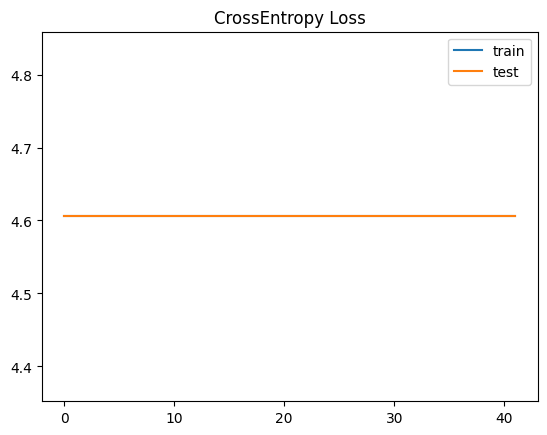

KeyboardInterrupt: 

In [ ]:
#Training VGG16 model
#EPOCH_NUM = 70
#EPOCH_NUM = 170
#train_loss_history, test_loss_history = [], []
#x_train, y_train = create_sample(data_dict), data_dict[b'fine_labels']
#x_test, y_test = create_sample(test_data_dict), test_data_dict[b'fine_labels']
#batch_size = 250
#batch_size = 250
#epsilon = 0.000001

#indices_by_batches = get_unique_indices_by_batches(data_dict[b'fine_labels'], 100, EPOCH_NUM, batch_size)
#batch_from_indices(data_dict, indices_by_batches[epoch_num])

for epoch_num in range(EPOCH_NUM):
    opt.zero_grad()
    #x_train_batch, y_train_batch = create_batch(x_train, y_train, train_labels_dict, batch_size)
    #x_train_batch, y_train_batch = create_batch(data_dict, batch_size)
    x_train_batch, y_train_batch = batch_from_indices(data_dict, indices_by_batches[epoch_num])
    y_batch_predicted = get_batch_prediction(vgg16_model, x_train_batch)
    loss = loss_function(y_batch_predicted, y_train_batch)
    loss.backward()
    opt.step()
    train_loss_history.append(loss.item())

    with torch.no_grad():
        #x_test_batch, y_test_batch = create_batch(x_test, y_test, test_labels_dict, 100)
        #x_test_batch, y_test_batch = create_batch(test_data_dict, 100)
        x_test_batch, y_test_batch = batch_from_indices(test_data_dict, indices_by_test_batches[epoch_num])
        y_predicted_test = get_batch_prediction(vgg16_model, x_test_batch)
        test_loss_history.append(loss_function(y_predicted_test, y_test_batch).item())

    '''
    if epoch_num > 1 and abs(train_loss_history[-1] - train_loss_history[-2]) < epsilon:
        opt.param_groups[0]['lr'] /= 1.1
        #opt.param_groups[0]['weight_decay'] /= 1.5
    '''

    clear_output(True)
    plt.plot(np.arange(len(train_loss_history)), train_loss_history, label='train')
    plt.plot(np.arange(len(test_loss_history)), test_loss_history, label='test')
    plt.title('CrossEntropy Loss')
    plt.legend()
    plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(train_loss_history[-1], test_loss_history[-1])
print(train_loss_history[-10:], test_loss_history[-10:])

4.60546875 4.60546875
[4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875] [4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875, 4.60546875]


In [ ]:
torch.rand(5).to(device = device)

In [ ]:
!nvidia-smi

In [ ]:
for name, param in vgg16_model.named_parameters():
    print(f'Name: {name} \n', param, '\n\n')

In [ ]:
# Testing model on the test data
vgg16_model.eval()
x_test_batch, y_test_batch = create_batch(test_data_dict, 400)
y_test_batch_predicted = get_batch_prediction(vgg16_model, x_test_batch, mode = 'test')
y_test_batch = y_test_batch.cpu().numpy()
y_test_batch_predicted = [x.cpu() for x in y_test_batch_predicted]
accuracy = accuracy_score(y_test_batch, y_test_batch_predicted)
precision = precision_score(y_test_batch, y_test_batch_predicted, average='macro')
recall = recall_score(y_test_batch, y_test_batch_predicted, average='macro')

print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')
print(y_test_batch)
print(y_test_batch_predicted)